In [2]:
import numpy as np
import torch as th
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.io import read_image
from pathlib import Path
import cv2
import os, tqdm, sys
import re

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20, 20)   # figsize

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_eyes&glasses&mouth&eyebrows':
        seg_m = (l_eye | r_eye | eye_g | l_brow | r_brow | mouth)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

def get_shadow_diff(img1, img2, c_type='L', signed=False):
    # Compute Shadow Difference
    img1 = np.array(img1.convert(c_type)) / 255.0
    img2 = np.array(img2.convert(c_type)) / 255.0
    if signed:
        shadow_diff = img2 - img1
    else:
        shadow_diff = np.abs(img2 - img1)
    return shadow_diff

def create_image_grid(images, n_rows=1):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image

# Settings up the paths

In [ ]:
# Dataset
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'train'
image_path = f'{data_path}/ffhq_256/{set_}/'
mask_path = f'{data_path}/face_segment/{set_}/anno/'
shadows_path = f'{data_path}/shadow_masks/{set_}/'
ckpt = 'ema_085000'


def progress(mode, model, n_frames, sampling_path, mothership=False):
    if mothership:
        progress_path = sampling_path
    else:
        if set_ == 'train':
            progress_path = f'/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPAMI/{mode}/{model}/{ckpt}/train_sub/'
        else:
            progress_path = f'/data/mint/DPM_Dataset/Soften_Strengthen_Shadows/TPAMI/{mode}/{model}/{ckpt}/{set_}/'
    if os.path.exists(progress_path):
        print("Available: ", sorted(os.listdir(progress_path)))
    
    img_path = []
    for p in sorted(os.listdir(progress_path)):
        if set_ == 'train':
            start = int(p.split('_')[1])
            end = int(p.split('_')[3])
            n = end - start
            tail = f'{progress_path}/{p}/shadow/reverse_sampling/'
        elif set_ == 'valid':
            assert p == 'shadow'
            n = 1
            tail = f'{progress_path}/shadow/reverse_sampling/'
            start = '60000'
        else: raise NotImplementedError(f"Set: {set_} is not found!")
        print(tail)
        count = 0
        for t in sorted(os.listdir(tail)):
            tmp = f'{tail}/{t}/dst={start}.jpg/Lerp_1000/n_frames={n_frames}/'
            if not os.path.exists(tmp):
                continue
            assert len(os.listdir(tmp)) == n_frames * 2 + 1
            count += 1
            img_path.append(tmp)
            
        print(f'[#] {p} => {count}/{n} => {count * 100/n:.2f}%')
    return img_path
            
        
def get_img_path(set_, mode, n_frames, mothership):
    # Sampling

    if mode == 'FFHQ_diffuse_face':
        model = 'log=Masked_Face_woclip+BgNoHead+shadow_256_cfg=Masked_Face_woclip+BgNoHead+shadow_256.yaml_tomin_steps=50'
    elif mode == 'FFHQ_shadow_face':
        model = 'log=difareli_canny=153to204bg_256_vll_cfg=difareli_canny=153to204bg_256_vll.yaml_tomax_steps=50'

    if set_ == 'train':
        sampling_path = f'/data/mint/sampling/TPAMI/{mode}/{model}/ema_085000/train_sub'
    else:
        sampling_path = f'/data/mint/sampling/TPAMI/{mode}/{model}/ema_085000/{set_}'
        
    img_path = sum([progress(mode=mode, model=model, n_frames=n_frames, sampling_path=sampling_path, mothership=ms) for ms in mothership], [])
    # regex src=([0-9]+).jpg/dst=([0-9]+).jpg from path
    sj_dict = {}
    for p in img_path:
        src = re.findall(r'src=([0-9]+).jpg', p)
        assert len(src) == 1
        dst = re.findall(r'dst=([0-9]+).jpg', p)
        assert len(dst) == 1
        
        sj_dict[src[0]] = p
        
    return img_path, sj_dict

n_frames_shadow = 5
n_frames_diffuse = 3
shadow_img, shadow_dict = get_img_path(set_=set_, mode='FFHQ_shadow_face', n_frames=n_frames_shadow, mothership=[False])
diffuse, diffuse_dict = get_img_path(set_=set_, mode='FFHQ_diffuse_face', n_frames=n_frames_diffuse, mothership=[False])

In [ ]:
out_dict = {k: {'shadow':shadow_dict[k], 'diffuse':diffuse_dict[k]} for k in shadow_dict if k in diffuse_dict}
# print(out_dict)
print(len(out_dict))

[#] Shadow value :  6.767856273058311 0.8727768178048351


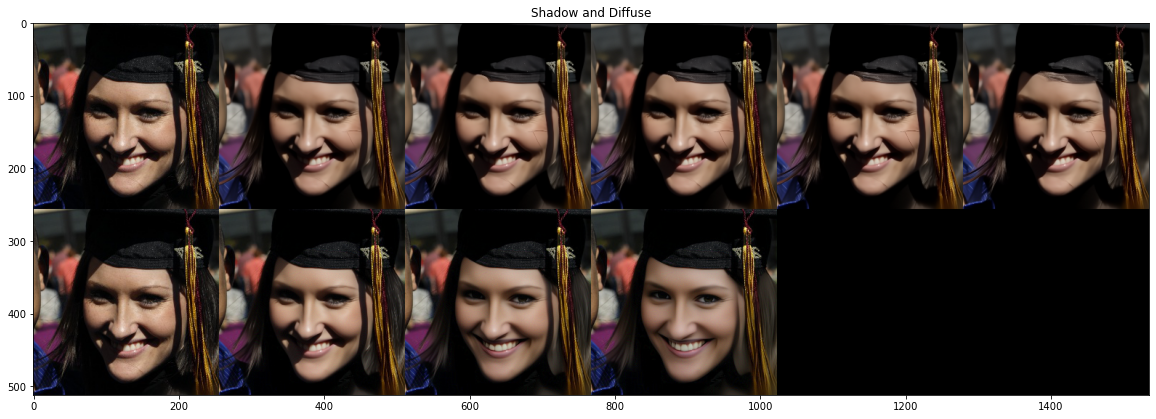

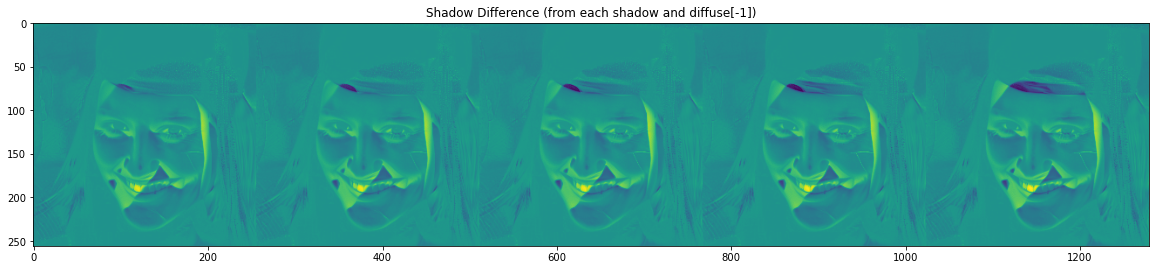

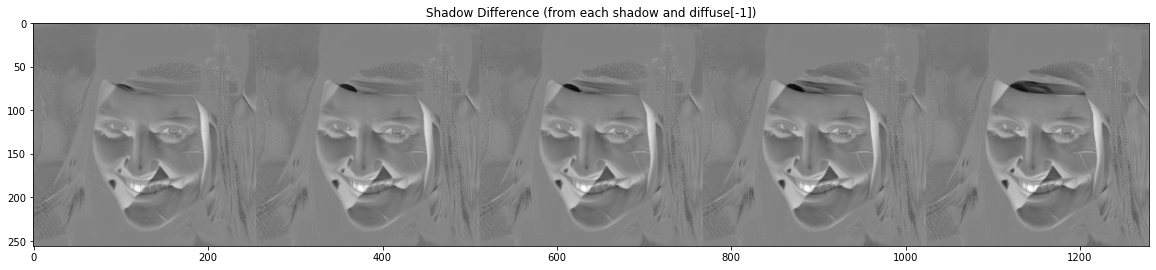

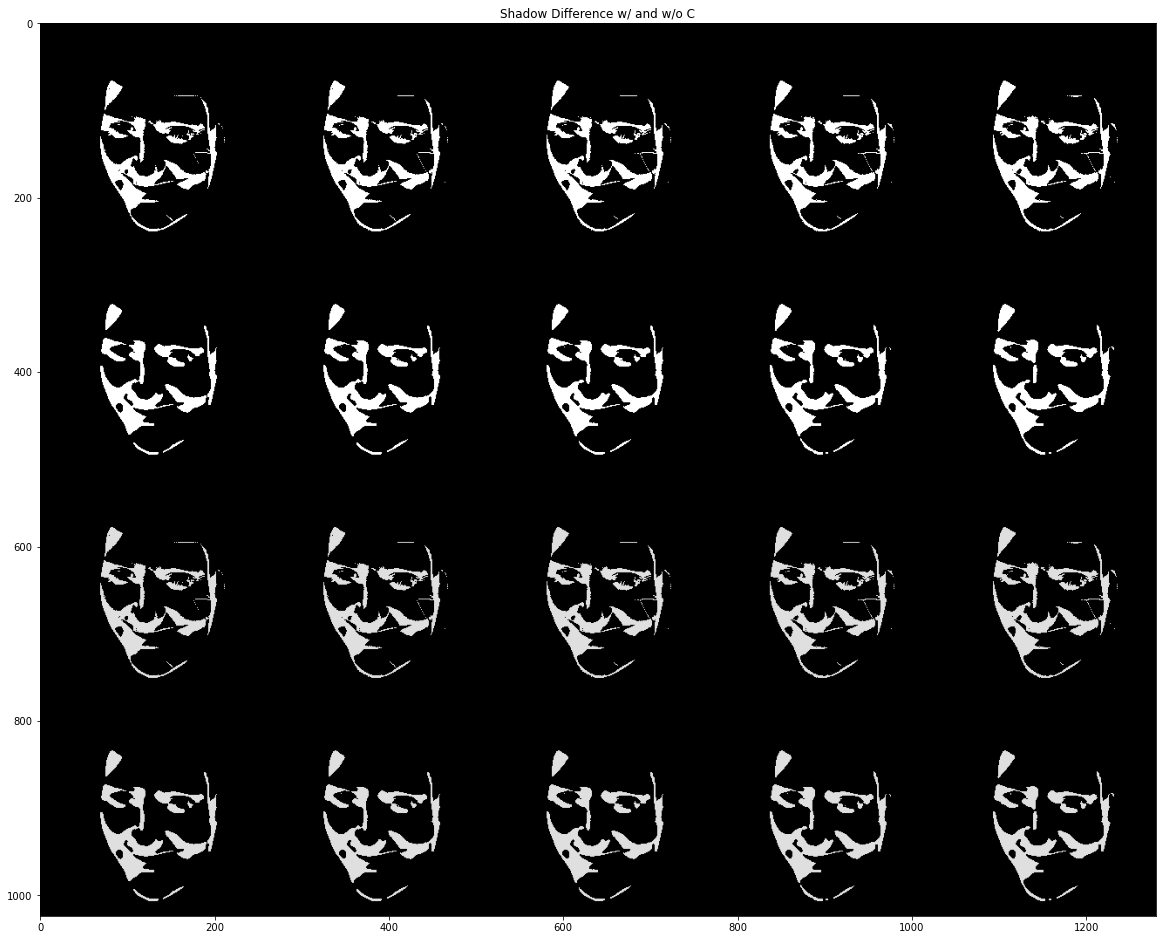

(256, 256) (256, 256)


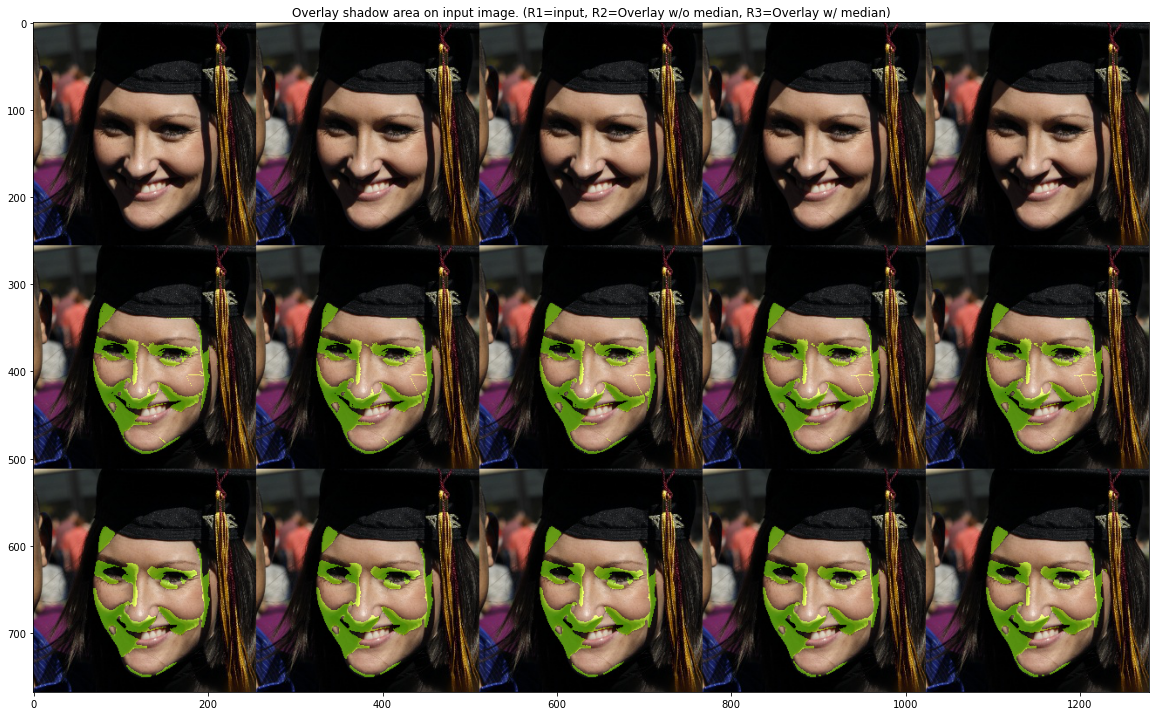

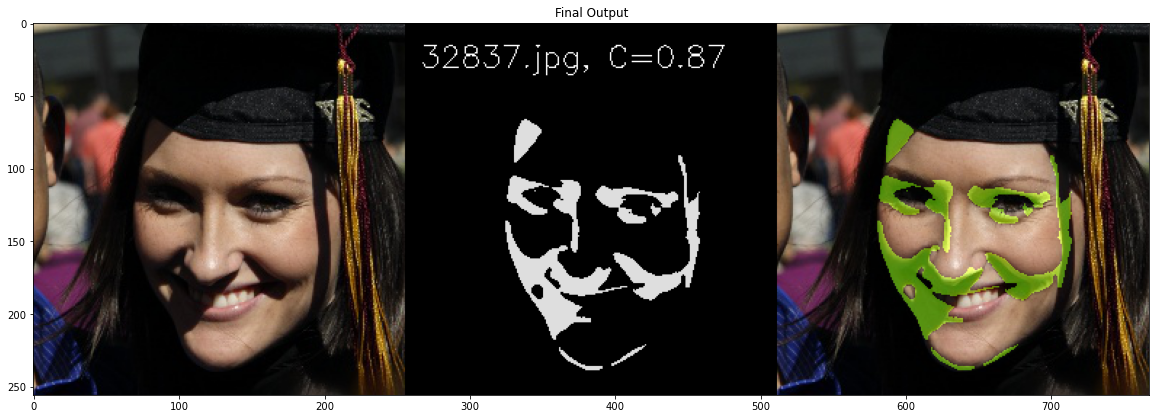

In [14]:
import glob
def process_smooth_shadow_diff(p_dict, img_name, 
                               shadow_idx, diffuse_idx,
                               save_vis=False, save_vis_path=None,
                               save_sd=False, save_sd_path=None, verbose=False,
                               ):
    # Save shape = (256, 256, 1), value = 0.0 to 1.0
    shadow = [Image.open(p_dict['shadow'] + f'/res_frame{i}.png') for i in range(n_frames_shadow)]
    diffuse = [Image.open(p_dict['diffuse'] + f'/res_frame{i}.png') for i in range(n_frames_diffuse)]
    face = Image.open(f'{image_path}/{img_name}.jpg')
    
    # Mask
    mask_image = Image.open(f'{mask_path}/anno_{img_name}.png')
    m_face = face_segment('faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses', mask_image)
    # m_glasses_and_eyes = face_segment('faceseg_eyes&glasses&mouth&eyebrows', mask_image)
    exclude = face_segment('faceseg_eyes&glasses&mouth&eyebrows', mask_image)
    
    # Shadow value (C)
    import pandas as pd
    max_c = 8.481700287326827 # 7.383497233314015
    min_c = -4.989461058405101 # -4.985533880236826
    c_p = f'{data_path}/params/{set_}/ffhq-{set_}-shadow-anno.txt'
    c = pd.read_csv(c_p, sep=' ', header=None, names=['image_name', 'c_val'])
    c_val = c[c['image_name'] == img_name + '.jpg']['c_val'].values[0]
    c_val_norm = (c_val - min_c)/(max_c - min_c)

    if verbose:
        print("[#] Shadow value : ", c_val, c_val_norm)
    
    s_grid = create_image_grid([face] + shadow, n_rows=1)
    d_grid = create_image_grid([face] + diffuse, n_rows=1)
    # print(s_grid.shape, d_grid.shape)
    if s_grid.shape[1] != d_grid.shape[1]:
        # Padding to the max
        to_pad = np.abs(s_grid.shape[1] - d_grid.shape[1])
        if s_grid.shape[1] > d_grid.shape[1]:
            d_grid = np.pad(d_grid, ((0, 0), (0, to_pad), (0, 0)), mode='constant', constant_values=0)
        else:
            s_grid = np.pad(s_grid, ((0, 0), (0, to_pad), (0, 0)), mode='constant', constant_values=0)
    
    c_type = 'L'
    shadow_diff_list = [get_shadow_diff(img1=shadow[i], img2=diffuse[diffuse_idx], c_type=c_type, signed=True) for i in range(n_frames_shadow)]
    if verbose:
        plt.imshow(np.concatenate((s_grid, d_grid), axis=0))
        plt.title("Shadow and Diffuse")
        plt.show()
        
        plt.imshow(create_image_grid(shadow_diff_list, n_rows=1))
        plt.title("Shadow Difference (from each shadow and diffuse[-1])")
        plt.show()
    
    thres = 0.05
    out = [
        (shadow_diff_list[0] < thres).astype(np.float32),
        (shadow_diff_list[1] < thres).astype(np.float32),
        (shadow_diff_list[2] < thres).astype(np.float32),
        (shadow_diff_list[3] < thres).astype(np.float32),
        (shadow_diff_list[4] < thres).astype(np.float32),
        cv2.medianBlur(((shadow_diff_list[0] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[1] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[2] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[3] < thres).astype(np.uint8)), 5),
        cv2.medianBlur(((shadow_diff_list[4] < thres).astype(np.uint8)), 5),
    ]
    out = [np.abs(1 - (t)) for t in out] # Invert the mask
    # out = [((t * ~m_glasses_and_eyes) + (0.0 * m_glasses_and_eyes))  for t in out] # Ensure glasses area always 1
    out = [((t * ~exclude) + (0.0 * exclude))  for t in out] # Ensure glasses area always 1
    out = [((t * m_face)) for t in out] # Ensure outer face area always 0.5
    
    out_W = [t * c_val_norm for t in out] # For each shadow area, assign shadow value
    
    out_hl = [np.repeat((t[..., None]*255).astype(np.uint8), 3, axis=2) for t in out.copy()]
    out_hl = [cv2.applyColorMap(t, cv2.COLORMAP_WINTER) * (t==255) for t in out_hl]
    overlay_img = [cv2.addWeighted(np.array(face), 1, t, 0.5, 0) for t in out_hl]

    if verbose:
        plt.imshow(create_image_grid(shadow_diff_list, n_rows=1), cmap='gray')
        plt.title("Shadow Difference (from each shadow and diffuse[-1])")
        plt.show()
        
        shadow_mask = out + out_W
        plt.imshow(create_image_grid(shadow_mask, n_rows=4), cmap='gray')
        plt.title("Shadow Difference w/ and w/o C")
        plt.show()
        print(out[-1].shape, out_W[-1].shape)
        Image.fromarray((np.repeat(out[4][..., None], repeats=3, axis=-1) * 255.0).astype(np.uint8)).convert('L').save(f'./compute_sdiff/sdiff_before_filter_{img_name}.png')
        Image.fromarray((np.repeat(out[-1][..., None], repeats=3, axis=-1) * 255.0).astype(np.uint8)).convert('L').save(f'./compute_sdiff/sdiff_with_wo_{img_name}.png')
        Image.fromarray((np.repeat(out_W[-1][..., None], repeats=3, axis=-1) * 255.0).astype(np.uint8)).convert('L').save(f'./compute_sdiff/sdiff_with_w_{img_name}.png')
        
        
        change = [face] * 5 + overlay_img
        plt.imshow(create_image_grid(change, n_rows=3))
        plt.title("Overlay shadow area on input image. (R1=input, R2=Overlay w/o median, R3=Overlay w/ median)")
        plt.show()
    
    vis_out_W = (np.repeat(out_W[shadow_idx][..., None], 3, axis=2) * 255.0).astype(np.uint8)
    cv2.putText(vis_out_W, f"{img_name}.jpg, C={c_val_norm:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
    
    # print(np.min(vis_out_W), np.max(vis_out_W), np.unique(vis_out_W))
    # print(np.min(face), np.max(face))
    # print(np.min(overlay_img[-1]), np.max(overlay_img[-1]))

    if verbose:
        final_out = [np.array(face)] + [vis_out_W] + [overlay_img[shadow_idx]]
        final_out = create_image_grid(final_out, n_rows=1)
        plt.imshow(final_out)
        plt.title("Final Output")
        plt.show()
    
    if save_vis:
        if save_vis_path is None:
            assert False, "[#] Save path is not provided!"
        final_out = [np.array(face)] + [vis_out_W] + [overlay_img[-1]]
        final_out = create_image_grid(final_out, n_rows=1)
        Image.fromarray(final_out).save(f'{save_vis_path}/{img_name}.png')
        # print(final_out.shape)
        # plt.imshow(final_out)
        # plt.savefig(f'{save_vis_path}/{img_name}.png')

    if save_sd:
        if save_sd_path is None:
            assert False, "[#] Save path is not provided!"
        final_out_sd_w = out_W[shadow_idx][..., None]
        assert final_out_sd_w.shape == (256, 256, 1)
        assert np.min(final_out_sd_w) >= 0.0 and np.max(final_out_sd_w) <= 1.0
        # print(final_out_sd_w.shape, np.unique(final_out_sd_w))
        # assert False
        np.save(f'{save_sd_path}/{img_name}.npy', final_out_sd_w)


shadow_idx = -1
diffuse_idx = -1
img_id = '32837'
process_smooth_shadow_diff(p_dict = out_dict[img_id], img_name=img_id, shadow_idx=-3, diffuse_idx=-1, verbose=True)
# save_sd_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff_SSmid_with_c_simplified/{set_}/'
# save_vis_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff_SSmid_with_c_simplified/vis/{set_}/'
# os.makedirs(save_sd_path, exist_ok=True)
# os.makedirs(save_vis_path, exist_ok=True)
# # assert False

# for k in tqdm.tqdm(out_dict.keys()):
#     process_smooth_shadow_diff(p_dict = out_dict[k], img_name=k, 
#                                save_vis=True, save_sd=True, 
#                                save_sd_path=save_sd_path, save_vis_path=save_vis_path, verbose=False,
#                                shadow_idx=shadow_idx, diffuse_idx=diffuse_idx)

In [ ]:
idx = 14
img_name = re.findall(r"src=\d+\.jpg", img_path[idx])[0].split('=')[1].split('.')[0]
print("[#] Image name: ", img_name)
face_image = Image.open(f'{image_path}/{img_name}.jpg')
mask_image = Image.open(f'{mask_path}/anno_{img_name}.png')
m_face = face_segment('faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses', mask_image)
m_glasses_and_eyes = face_segment('faceseg_eyes&glasses', mask_image)
cast_shadows = Image.open(f'{shadows_path}/{img_name}.png')

import pandas as pd
c_p = f'{data_path}/params/{set_}/ffhq-{set_}-shadow-anno.txt'
c = pd.read_csv(c_p, sep=' ', header=None, names=['image_name', 'c_val'])
c_val = c[c['image_name'] == img_name + '.jpg']['c_val'].values[0]

max_c = 8.481700287326827 # 7.383497233314015
min_c = -4.989461058405101 # -4.985533880236826
print("[#] Shadow value : ", c_val, (c_val - min_c)/(max_c - min_c))
reshadow_img = [face_image] + [Image.open(f'{img_path[idx]}/res_frame{f}.png') for f in range(n_frames)]
plt.figure(figsize=(30, 30))
plt.imshow(create_image_grid(reshadow_img, 1), cmap='gray')
plt.show()

c_type = 'L'
out = []
print(len(reshadow_img))
for i in range(len(reshadow_img)):
    out.append(get_shadow_diff(img1=reshadow_img[i], img2=reshadow_img[0], c_type=c_type, signed=True))

print("[#] Shadow difference: ")
plt.figure(figsize=(30, 30))
plt.imshow(create_image_grid(out, 1), cmap='gray')
plt.show()

print("[#] Shadow difference (CC): ")
plt.figure(figsize=(30, 30))
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'yellow', 'red'])
# out_cc = [(out[i] - np.min(out[i]))/(np.max(out[i]-np.min(out[i]) + 1e-16)) for i in range(len(out))]
out_cc = [(out[i]+1)/0.5 for i in range(len(out))]
plt.imshow(create_image_grid(out_cc, 1), cmap=cmap)
plt.show()
    
print("[#] Thresholding the shadow difference: ")
plt.figure(figsize=(30, 30))
plt.imshow(create_image_grid(out, 1) < 0, cmap='gray')
plt.show()

print("[#] Preprocessing the shadow difference: ")
print(np.min(out[-1]), np.max(out[-1]), out[-1].shape)
thres = 0.05
inp_face = (np.array(face_image.convert(c_type))/255.0).astype(np.float32)
cast_shadows = np.array(cast_shadows) / 255.0
assert np.all(cast_shadows[..., 0] == cast_shadows[..., 1])
assert np.all(cast_shadows[..., 0] == cast_shadows[..., 2])
reshadow_idx = -2
tmp = [
    (out[reshadow_idx] < thres).astype(np.float32),
    (out[reshadow_idx] < -0.1).astype(np.float32),
    (out[reshadow_idx] < -0.2).astype(np.float32),

    cv2.medianBlur(((out[reshadow_idx] < thres).astype(np.uint8)), 3),
    cv2.medianBlur(((out[reshadow_idx] < thres).astype(np.uint8)), 5),
    cv2.medianBlur(((out[reshadow_idx] < thres).astype(np.uint8)), 7),

    (out[reshadow_idx] > thres).astype(np.float32),
    (out[reshadow_idx] > -0.1).astype(np.float32),
    (out[reshadow_idx] > -0.2).astype(np.float32),
    
    cv2.medianBlur(((out[reshadow_idx] > thres).astype(np.uint8)), 3),
    cv2.medianBlur(((out[reshadow_idx] > thres).astype(np.uint8)), 5),
    cv2.medianBlur(((out[reshadow_idx] > thres).astype(np.uint8)), 7),
    
    (cast_shadows[..., 0] < 0.3).astype(np.float32),
    (cast_shadows[..., 0] < 0.5).astype(np.float32),
    (cast_shadows[..., 0] < 0.7).astype(np.float32),
]
# plt.figure(figsize=(15, 15))
# tmp = [(np.abs(1 - (t)) * m_face) for t in tmp] # Invert the mask
# plt.imshow(create_image_grid(tmp, 2), cmap='gray')
# plt.show()
# tmp = [np.abs(1 - (t)) for t in tmp] # Invert the mask
# tmp = [(((t * ~m_glasses_and_eyes) + (1.0 * m_glasses_and_eyes)) * m_face) + (0.5 * ~m_face)  for t in tmp] # Ensure glasses area always 1
# plt.figure(figsize=(15, 15))
# for t in tmp:
#     print(t.shape)
#     print(np.max(t), np.min(t))
tmp = [np.abs(1 - (t)) for t in tmp] # Invert the mask
tmp = [((t * ~m_glasses_and_eyes) + (1.0 * m_glasses_and_eyes))  for t in tmp] # Ensure glasses area always 1
tmp = [((t * m_face) + (0.5 * ~m_face)) for t in tmp] # Ensure outer face area always 0.5
plt.imshow(create_image_grid(tmp, 5), cmap='gray')
plt.show()